In [26]:
import csv
import glob
import pathlib

import cv2
import imutils
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import to_categorical


base_path = "CK+48"
files=os.listdir(base_path)


emotions=['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']

In [15]:
import cv2

count_file_under_emotions=[]
images=[]
labels=[]
for emotion_dir in files:
    idx=emotions.index(emotion_dir)
    label=idx
    i=0
  
    one_emotion_dir = base_path + '/' + emotion_dir
    files_under_one_emotion = os.listdir(one_emotion_dir)
    for file_under_one_emotion in files_under_one_emotion:
        file_main=one_emotion_dir+'/'+file_under_one_emotion
        #print(file_main+"   "+str(label))
        image= cv2.imread(file_main)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image= cv2.resize(image,(48,48))
        images.append(image)
        labels.append(label)
        i+=1
    count_file_under_emotions.append(i)

In [14]:
count_file_under_emotions

[135, 54, 177, 75, 207, 84, 249]

In [17]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten,BatchNormalization
from tensorflow.keras.layers import Dense, MaxPooling2D,Conv2D
from tensorflow.keras.layers import Input,Activation,Add
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam


def conv_layers(input_tensor, filters):
    
    x = Conv2D(filters=filters,kernel_size=(3, 3),padding = 'same',strides=(1, 1),kernel_regularizer=l2(0.001))(input_tensor)
    x = Dropout(0.1)(x)
    x= Activation('relu')(x)
    return x

def build_model(input_shape):
    inputs = Input((input_shape))

    conv_1= conv_layers(inputs,32)
    maxp_1 = MaxPooling2D(pool_size = (2,2)) (conv_1)
    conv_2 = conv_layers(maxp_1,64)
    maxp_2 = MaxPooling2D(pool_size = (2, 2)) (conv_2)
    conv_3 = conv_layers(maxp_2,128)
    maxp_3 = MaxPooling2D(pool_size = (2, 2)) (conv_3)
    conv_4 = conv_layers(maxp_3,256)
    maxp_4 = MaxPooling2D(pool_size = (2, 2)) (conv_4)
    flatten= Flatten() (maxp_4)
    dense_1= Dense(128,activation='relu')(flatten)
    drop_1=Dropout(0.2)(dense_1)
    output= Dense(7,activation="sigmoid")(drop_1)
    model = Model(inputs=[inputs], outputs=[output])
    model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])
    
    return model

In [22]:
model = build_model((48,48,3))

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
dropout_10 (Dropout)         (None, 48, 48, 32)        0         
_________________________________________________________________
activation_8 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
dropout_11 (Dropout)         (None, 24, 24, 64)        0   

In [27]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np

images_arr = np.array(images)
labels_arr = np.array(labels)
images_scaled_arr = images_arr/255

labels_encoded = tf.keras.utils.to_categorical(labels_arr, num_classes=len(emotions))

X_train, X_non_train, Y_train, Y_non_train= train_test_split(images_scaled_arr, labels_encoded, test_size=0.25)

In [30]:
BATCH_SIZE = 32
EPOCHS = 2

checkpoint_pattern = ('model/model-emotions-ep{epoch:03d}-loss{loss:.3f}'
                          '-val_loss{val_loss:.3f}.h5')

checkpoint = ModelCheckpoint(checkpoint_pattern,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')



train_augmenter = ImageDataGenerator(rotation_range=10,
                                     zoom_range=0.1,
                                     horizontal_flip=True,                                     
                                     fill_mode='nearest')

train_gen = train_augmenter.flow(X_train,
                                 Y_train,
                                 batch_size=BATCH_SIZE)

train_steps = len(X_train) // BATCH_SIZE

val_augmenter = ImageDataGenerator(rotation_range=10,
                                     zoom_range=0.1,
                                     horizontal_flip=True,                                     
                                     fill_mode='nearest')

X_valid = X_non_train[:len(X_non_train)//2]
Y_valid = Y_non_train[:len(X_non_train)//2]

X_test = X_non_train[len(X_non_train)//2:]
Y_test = Y_non_train[len(X_non_train)//2:]

val_gen = val_augmenter.flow(X_valid,
                             Y_valid,
                             batch_size=BATCH_SIZE)


model.fit(train_gen,
          steps_per_epoch=train_steps,
          validation_data=val_gen,
          epochs=EPOCHS,
          verbose=1,
          callbacks=[checkpoint])

test_augmenter = ImageDataGenerator(rotation_range=10,
                                     zoom_range=0.1,
                                     horizontal_flip=True,                                     
                                     fill_mode='nearest')

test_gen = test_augmenter.flow(X_test,
                               Y_test,
                               batch_size=BATCH_SIZE)
test_steps = len(X_test) // BATCH_SIZE
_, accuracy = model.evaluate(test_gen, steps=test_steps)

print(f'Accuracy: {accuracy * 100}%')

Epoch 1/2
22/22 [==============================] - 6s 271ms/step - loss: 1.8622 - accuracy: 0.3343 - val_loss: 1.8012 - val_accuracy: 0.4228

Epoch 00001: val_loss improved from inf to 1.80117, saving model to age-gender-CKPLUS/model\model-emotions-ep001-loss1.862-val_loss1.801.h5
Epoch 2/2
22/22 [==============================] - 5s 230ms/step - loss: 1.4859 - accuracy: 0.4979 - val_loss: 1.4521 - val_accuracy: 0.5041

Epoch 00002: val_loss improved from 1.80117 to 1.45205, saving model to age-gender-CKPLUS/model\model-emotions-ep002-loss1.486-val_loss1.452.h5
3/3 [==============================] - 0s 65ms/step - loss: 1.3394 - accuracy: 0.6146
Accuracy: 61.45833134651184%


In [34]:
from sklearn.metrics import classification_report 

predictions = model.predict(X_test)

i=0 
Y_test_label = [] 
predictions_label = []

for i in range(len(predictions)):   
    Y_test_label.append(int(np.argmax(Y_test[i])))     
    predictions_label.append(int(np.argmax(predictions[i])))   

report = classification_report(Y_test_label, predictions_label)

C:\Users\venka\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\venka\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\venka\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
import matplotlib.pyplot as plt
def test_image(ind):
    plt.imshow(images_arr[ind])
    image_test = images_arr[ind]
    print("Label actual:  " + emotions[labels[ind]])
    pred = model.predict(np.array([images_arr[ind]]))
    #print(pred_1)
    pred_class = emotions[int(np.argmax(pred))]
    print("Predicted Label: "+ pred_class)

Label actual:  surprise
Predicted Label: fear


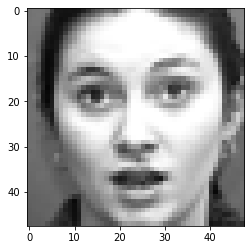

In [43]:
test_image(789)